# Classification problem Part2

Follow up of part1. Here we are going to test the Logistic Regression Model

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt


## Data

The main dataset is obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records) and consists of votes made by US House of Representatives Congressmen. The goal is to predict their party affiliation ('Democrat' or 'Republican') based on how they voted on certain key issues. 

The dataset has been dowloaded locally at _path_datafile_

In [2]:
# Identify path of the repository
path=os.getcwd().split('ds_portfolio')[0]
path

'/Users/locupe/Dropbox/Perso/Dataproject/'

In [3]:
path_datafile = path + 'ds_portfolio/data/raw/house-votes-84.data'

In [4]:
# Define header name for csv importation
header_list = ["party", "infants", "water", "budget",
               "physician", "salvador", "religious", 
               "satellite", "aid", "missile", "immigration", 
               "synfuels", "education", "superfund", "crime", 
               "duty_free_exports", "eaa_rsa" 
              ]

# Import csv
df0 = pd.read_csv(path_datafile, names=header_list)
df0.head()

,party,infants,water,budget,physician,salvador,religious,satellite,aid,missile,immigration,synfuels,education,superfund,crime,duty_free_exports,eaa_rsa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


## Preprocessing

#### Dropping missing data

In [5]:
df = df0
# Convert '?' to NaN
df[df == '?'] = np.nan

## Print the number of NaNs
#print(df.isnull().sum())

# Print shape of original DataFrame
print(f"Shape of Original DataFrame: {df.shape}")

# Drop missing values and print shape of new DataFrame
df = df.dropna()

# Print shape of new DataFrame
print(f"Shape of DataFrame After Dropping all the missing values: {df.shape}")

Shape of Original DataFrame: (435, 17)
Shape of DataFrame After Dropping all the missing values: (232, 17)


#### Need to replace string by number

In [6]:
df=df.replace(to_replace=['n', 'y'], value=[0, 1])

## Logistic Regression model

In [7]:
y = df['party'].values
X = df.drop('party', axis=1).values

In [8]:
# Import the necessary modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)
# The stratify parameter asks whether you want to retain the same proportion of classes 
# in the train and test sets that are found in the entire original dataset. 

# Create the classifier: logreg
logreg = LogisticRegression()


#### Plotting the Receiver operating characteristic curve

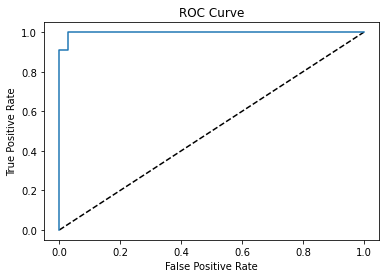

AUC: 0.9975429975429975


In [10]:
# Import necessary modules
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score 
from sklearn.model_selection import cross_val_score

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]


# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob,pos_label='republican')

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Compute and print AUC score
print(f"AUC: {roc_auc_score(y_test, y_pred_prob)}")

In [11]:

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')

# Print list of AUC scores
print(f"AUC scores computed using 10-fold cross-validation: {cv_auc}")
print(f"Average 10-fold CV Score: {np.mean(cv_auc)}")


AUC scores computed using 10-fold cross-validation: [1.         0.98601399 1.         0.98461538 1.         1.
 1.         1.         0.9469697  0.99242424]
Average 10-fold CV Score: 0.9910023310023309


### Additional preprocessing steps

#### Pipeline

-> use to chain multiple estimators into one. Useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes:
* Convenience and encapsulation: *You only have to call fit and predict once on your data to fit a whole sequence of estimators.*
* Joint parameter selection: *You can grid search over parameters of all estimators in the pipeline at once.*
* Safety: *Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.*


#### Imputation of missing values
Previouslty we discard entire rows containing missing values. However, this comes at the price of losing data which may be valuable (even though incomplete). A better strategy is to impute the missing values, i.e., to infer them from the known part of the data.
(see more info here: https://scikit-learn.org/stable/modules/impute.html)

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Setup the pipeline steps: steps
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
steps = [('imp', imp),
        ('LR', LogisticRegression())]

# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Need to replace string by number
df0=df0.replace(to_replace=['n', 'y'], value=[0, 1])
# Create arrays for the features and the response variable
y = df0['party'].values
X = df0.drop('party', axis=1).values

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

# Fit the pipeline to the train set
pipeline.fit(X_train,y_train)

# Predict the labels of the test set
y_pred = pipeline.predict(X_test)




#### Normalizing the data
Scaling is very important as many machine learning models use some form of distance to inform them. If features are on larger scales than other features they can wrongly influence the model.
Eg. k-NN uses distance explicitly when making prediction

Several types of normalization exist (e.g. all features are centered on 0 and have variance one, substract the minimum and divide by range, set the minimum at zero and maximum at one, ...)

Here, the different features are already normalized (only a value of 0 or 1).

### Validation curve

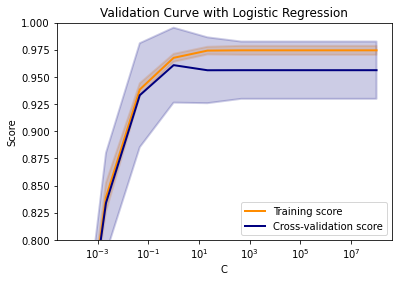

In [13]:
from sklearn.model_selection import validation_curve
param_range = np.logspace(-4, 8, 10)
train_scores, test_scores = validation_curve(pipeline, X, y,
                                          param_name="LR__C",
                                          param_range=param_range, 
                                          scoring="accuracy",
                                          cv=10)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic Regression")
plt.xlabel("C")
plt.ylabel("Score")
plt.ylim(0.8, 1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

**Note**: For Logistic Regression models, small C values will increase the regularization strength which implies the creation of simple models that tend to underfit the data. By using bigger C values, the model can increase it's complexity and adjust better to the data.

Here the best model appear to have a C value between 0 and 10

### Learning curve

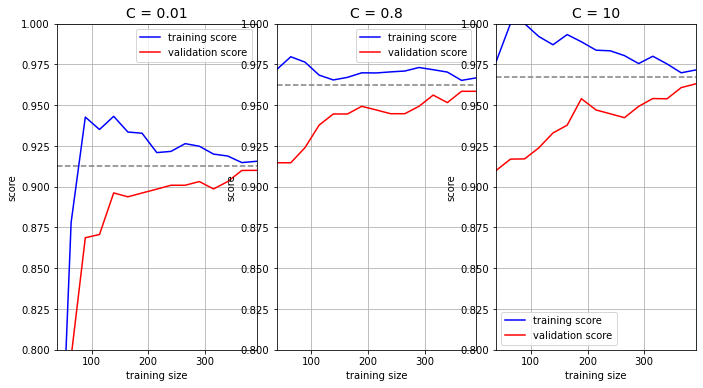

In [14]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 3, figsize=(10, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')    

for i, degree in enumerate([0.01, 0.8, 10]):
    
    # Setup the pipeline steps: steps
    pipe2 = Pipeline([('imp', imp),
            ('LR', LogisticRegression(C=degree))])

    N, train_lc, val_lc = learning_curve(pipe2,
                                         X, y, cv=10,
                                         train_sizes=np.linspace(0.1, 1, 15))

    ax[i].grid()
    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0.8, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('C = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')



**Note**: We can see that for C~0.8, the score is almost similar to more complex model (C=10). In the complex model, the slight improvement of the score of convergence (dashed line) is done at the expense of higher model variance (difference between training and validation scores)

### Hyperparameters tuning

Hyperparameters cannot be learned by fitting the model (k for k-nearest neighour, alpha for lasso or ridge regression)

Idea: 1) Choose a range of hyperparameter values and arrange them in a grid; 2) try all of them separately; 3) see how well each perform; 4) Choose the best performing one

It is essential to use cross-validation to reduce the bias in modeling our data with a specific subset of data


#### Logistic regression

Logistic regression also has a regularization parameter: _C_. _C_ controls the inverse of the regularization strength, and this is what you will tune in this exercise. A large C can lead to an overfit model, while a small C can lead to an underfit model.


In [15]:
LogisticRegression().penalty

'l2'

Logistic regression is using by default a _'l2'_ penalisation which penalize large coefficients for the fit. It is usefull to avoid overfitting

#### Grid searching of hyperparameters

Grid search is an approach to hyperparameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid. 


In [16]:
# Import necessary modules
from sklearn.model_selection import GridSearchCV

# Setup the pipeline steps: steps
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
steps = [('imp', imp),
        ('LR', LogisticRegression())]

# Create the pipeline: pipeline
pipeline = Pipeline(steps)


In [31]:
# Setup the hyperparameter grid
c_space = np.logspace(-2, 3, 15)
param_grid = {'imp__strategy':['mean', 'median', 'most_frequent'],
    'LR__C': c_space}

# Instantiate the GridSearchCV object: pipeline_cv
pipeline_cv = GridSearchCV(pipeline, param_grid, cv=10, scoring='roc_auc')

# Fit it to the data
pipeline_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(pipeline_cv.best_params_)) 
print("Best score is {}".format(pipeline_cv.best_score_))



Tuned Logistic Regression Parameters: {'LR__C': 1.3894954943731375, 'imp__strategy': 'mean'}
Best score is 0.9929728087816324


## Notes on the models used

#### Logistic regression

**Advantages**

* Easy, fast and simple classification method.
* Can be used for multiclass classifications also.


**Disadvantages**

* Cannot be applied on non-linear classification problems.
* Colinearity and outliers tampers the accuracy of LR model.


**Hyperparameters**

Logistic regression hyperparameters are similar to that of linear regression and have to be tuned properly to achieve high accuracy.


**Assumptions of LR**

Logistic regression assumptions are similar to that of linear regression model.
   * Linear relationship between the independent and dependent variables.
   * Training data have to be homoskedastic, meaning the variance of the errors should be somewhat constant.
   * Independent variables should not be co-linear.
 

#### Logistic Regression vs KNN

  * KNN is a non-parametric model, where LR is a parametric model.
  * KNN is comparatively slower than Logistic Regression.
  * KNN supports non-linear solutions where LR supports only linear solutions.
  * LR can derive confidence level (about its prediction), whereas KNN can only output the labels.


#### Other algorithms for binary classification
* Decision Trees
* Support Vector Machine
* Naive Bayes


####  Algorithms for multi-class classification
* k-Nearest Neighbors.
* Decision Trees.
* Naive Bayes.
* Random Forest.
* Gradient Boosting.


Algorithms that are designed for binary classification (LR, SVM) can be adapted for use for multi-class problems. This involves using a strategy of fitting multiple binary classification models for each class vs. all other classes (called one-vs-rest) or one model for each pair of classes (called one-vs-one).


**Ideas for further work**:
* Try to implement *RandomizeSearchCV* and *BayesianSearch* instead of the regular *GridSearchCV*
* Try other algorithms such as Decision Trees or Support Vector Machine